# Importar librerias

In [3]:
!pip install ucimlrepo
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.5 MB/s eta 0:00:003.3 MB/s eta 0:00:01


In [7]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# print(sys.executable)

# Manipulación y prepración de datos
* Importar los conjuntos de datos con los que se trabajará.
* Realizar tareas de limpieza de datos, eliminando valores nulos o inconsistentes.
* Realizar transformaciones necesarias para preparar los datos para el análisis y modelado.

## Obtener los datos

In [5]:

from ucimlrepo import fetch_ucirepo 
  
appendicitis_data = fetch_ucirepo(id=938) 
  
# X and y
X = appendicitis_data.data.features 
y = appendicitis_data.data.targets 
  
# metadata 
print(appendicitis_data.metadata) 
  
# variable information 
print(appendicitis_data.variables[:5]) 


{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

In [8]:

# Export raw data to specific folder
raw_df = pd.concat([X,y], axis = 1)
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
path = os.path.join(parent_directory,'data/raw/uci_df_raw.csv')
print(path)
raw_df.to_csv(path)

/Users/kevin/Desktop/MLOps/mlops_tec/mlops_tarea1/data/raw/uci_df_raw.csv


* Realizar tareas de limpieza de datos, eliminando valores nulos o inconsistentes.

In [10]:
features_df = appendicitis_data.variables

In [19]:
# Filter numeric 
continuous_df = features_df.query("type == 'Continuous' and role == 'Feature'")
continuous_feature_names = continuous_df['name'].unique()
continuous_features = list(continuous_feature_names)
continuous_features

['Age',
 'BMI',
 'Height',
 'Body_Temperature',
 'WBC_Count',
 'RBC_Count',
 'Hemoglobin',
 'RDW']

In [12]:
categorical_df = features_df.query("type == 'Categorical' and role == 'Feature'")
categorical_feature_names = categorical_df['name'].unique()
categorical_features_list = list(categorical_feature_names)
categorical_features_list


['Sex',
 'Neutrophilia',
 'Ketones_in_Urine',
 'RBC_in_Urine',
 'WBC_in_Urine',
 'Stool',
 'Peritonitis',
 'Psoas_Sign',
 'Ipsilateral_Rebound_Tenderness',
 'US_Performed',
 'Free_Fluids',
 'Appendix_Wall_Layers',
 'Target_Sign',
 'Appendicolith',
 'Perfusion',
 'Perforation',
 'Surrounding_Tissue_Reaction',
 'Appendicular_Abscess',
 'Abscess_Location',
 'Lymph_Nodes_Location',
 'Ileus',
 'Coprostasis',
 'Meteorism',
 'Enteritis',
 'Gynecological_Findings']

In [18]:
binary_df = features_df.query("type == 'Binary' and role == 'Feature'")
binary_feature_names = binary_df['name'].unique()
binary_features = list(binary_feature_names)
binary_features

['Appendix_on_US',
 'Migratory_Pain',
 'Lower_Right_Abd_Pain',
 'Contralateral_Rebound_Tenderness',
 'Coughing_Pain',
 'Nausea',
 'Loss_of_Appetite',
 'Dysuria',
 'Pathological_Lymph_Nodes',
 'Bowel_Wall_Thickening',
 'Conglomerate_of_Bowel_Loops']

In [14]:
integer_df = features_df.query("type == 'Integer' and role == 'Feature'")
integer_features = integer_df['name'].unique()
integer_features = list(integer_features)
integer_features

['Weight',
 'Length_of_Stay',
 'Alvarado_Score',
 'Paedriatic_Appendicitis_Score',
 'Appendix_Diameter',
 'Neutrophil_Percentage',
 'Segmented_Neutrophils',
 'Thrombocyte_Count',
 'CRP']

In [15]:
data_nulls = X.isnull().sum()
df_nulls = pd.DataFrame(data_nulls, columns=['Nulls'])
df_nulls.reset_index(inplace=True)
df_nulls.rename(columns={'index': 'Feature'}, inplace=True)
df_nulls.head()


,Feature,Nulls
0,Age,1
1,BMI,27
2,Sex,2
3,Height,26
4,Weight,3


There are null values for categorial variables which seem to indicate not the lack of value but more the absence of a desease

In [17]:
records = len(X)
df_percentage_nulls = df_nulls.copy()
df_percentage_nulls['total_records'] = records
df_percentage_nulls['nulls_percent(%)'] = (df_percentage_nulls['Nulls'] / records) * 100
df_percentage_nulls.head()
df_percentage_nulls.sort_values(by='nulls_percent(%)', ascending=False).head()


,Feature,Nulls,total_records,nulls_percent(%)
43,Abscess_Location,769,782,98.337596
52,Gynecological_Findings,756,782,96.675192
47,Conglomerate_of_Bowel_Loops,739,782,94.501279
19,Segmented_Neutrophils,728,782,93.094629
48,Ileus,722,782,92.327366


In [20]:
# calculate null values for continuous variables
filtered_df = df_percentage_nulls[df_percentage_nulls['Feature'].isin(continuous_features)]
filtered_df


,Feature,Nulls,total_records,nulls_percent(%)
0,Age,1,782,0.127877
1,BMI,27,782,3.452685
3,Height,26,782,3.324808
16,Body_Temperature,7,782,0.895141
17,WBC_Count,6,782,0.767263
21,RBC_Count,18,782,2.301790
22,Hemoglobin,18,782,2.301790
23,RDW,26,782,3.324808


In [21]:
for feature in continuous_features:
    mean_value = X[feature].mean()    
    # Fill NaN values with the median of the column
    X.loc[:, feature] = X[feature].fillna(mean_value)

for feature in integer_features:
    mean_value = X[feature].mean()    
    # Fill NaN values with the median of the column
    X.loc[:, feature] = X[feature].fillna(mean_value)    

In [22]:
data_nulls = X.isnull().sum()
df_nulls = pd.DataFrame(data_nulls, columns = ['Nulls'])
df_nulls.reset_index(inplace = True)
df_nulls.rename(columns = {'index':'Feature'}, inplace = True)
df_nulls.sort_values(by = 'Nulls', ascending= False).head()

,Feature,Nulls
43,Abscess_Location,769
52,Gynecological_Findings,756
47,Conglomerate_of_Bowel_Loops,739
48,Ileus,722
39,Perfusion,719


* Realizar transformaciones necesarias para preparar los datos para el análisis y modelado.

In [23]:

for feature in categorical_features_list:
    # print("cat ",feature," before")
    # print(X[feature].unique())
    X.loc[:, feature] = X[feature].fillna('Not present') 
    # print("cat ",feature," after")
    # print(X[feature].unique())       

for feature in binary_features:
    # print("bin ",feature," after")
    # print(X[feature].unique())
    X.loc[:, feature] = X[feature].fillna('Unkown') 
    # print("bin ",feature," after")
    # print(X[feature].unique())    

In [24]:
# validar datos nulos finales después de transformación para variables continuas, categóricas, binarias e integers
data_nulls = X.isnull().sum()
df_nulls = pd.DataFrame(data_nulls, columns = ['Nulls'])
df_nulls.reset_index(inplace = True)
df_nulls.rename(columns = {'index':'Feature'}, inplace = True)
df_nulls.sort_values(by = 'Nulls', ascending= False)

,Feature,Nulls
0,Age,0
27,WBC_in_Urine,0
29,Dysuria,0
30,Stool,0
31,Peritonitis,0
32,Psoas_Sign,0
33,Ipsilateral_Rebound_Tenderness,0
34,US_Performed,0
35,Free_Fluids,0
36,Appendix_Wall_Layers,0


* Integrar variable dependiente e independiente en un solo dataset

In [25]:
X.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.100000,...,Not present,yes,reUB,Unkown,Unkown,Not present,Not present,Not present,Not present,Not present
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,7.762651,...,Not present,Unkown,Not present,Unkown,Unkown,Not present,Not present,yes,Not present,Not present
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,7.762651,...,Not present,Unkown,Not present,Unkown,Unkown,Not present,Not present,yes,yes,Not present
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,7.762651,...,Not present,yes,reUB,Unkown,Unkown,Not present,Not present,Not present,yes,Not present
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.000000,...,Not present,yes,reUB,Unkown,Unkown,Not present,Not present,Not present,yes,Not present


In [26]:
# la variable a predecir será sólo el diagnóstico no el nivel de severidad / management
y.head()

,Management,Severity,Diagnosis
0,conservative,uncomplicated,appendicitis
1,conservative,uncomplicated,no appendicitis
2,conservative,uncomplicated,no appendicitis
3,conservative,uncomplicated,no appendicitis
4,conservative,uncomplicated,appendicitis


In [27]:
y = y['Diagnosis']
y = pd.DataFrame(y)
y.head()

,Diagnosis
0,appendicitis
1,no appendicitis
2,no appendicitis
3,no appendicitis
4,appendicitis


# Exploración y preprocesamiento de datos
* Realizar análisis exploratorio de datos (EDA) utilizando visualizaciones y estadísticas descriptivas.
* Aplicar técnicas de preprocesamiento como normalización, codificación de variables categóricas y reducción de dimensionalidad.


* Estadísticas descriptivas

In [22]:
X.describe()

,Age,BMI,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_Diameter,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP
count,782.000000,782.000000,782.00000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,11.346451,18.907012,148.01746,43.172542,4.284062,5.921918,5.253425,7.762651,37.404516,12.670683,71.791163,64.929630,4.799490,13.380497,13.180291,285.252618,31.386900
std,3.527649,4.308862,19.40079,17.357550,2.567457,2.082962,1.892135,2.023563,0.899619,5.345871,13.476199,3.929691,0.493228,1.377122,4.462585,71.654101,57.027956
min,0.000000,7.830000,53.00000,3.960000,1.000000,0.000000,0.000000,2.700000,26.900000,2.600000,27.200000,32.000000,3.620000,8.200000,11.200000,91.000000,0.000000
25%,9.210000,15.805000,138.00000,29.500000,3.000000,4.000000,4.000000,7.000000,36.800000,8.300000,63.825000,64.929630,4.540000,12.700000,12.300000,236.000000,1.000000
50%,11.440000,18.280000,149.00000,41.450000,3.000000,6.000000,5.000000,7.762651,37.200000,12.000000,71.900000,64.929630,4.790000,13.380497,12.800000,277.000000,7.000000
75%,14.080000,21.015000,162.22500,54.000000,5.000000,8.000000,6.000000,8.000000,37.900000,16.200000,82.375000,64.929630,5.010000,14.000000,13.300000,328.750000,32.000000
max,18.360000,38.160000,192.00000,103.000000,28.000000,10.000000,10.000000,17.000000,40.200000,37.700000,97.700000,91.000000,14.000000,36.000000,86.900000,708.000000,365.000000


* Distribución de los datos

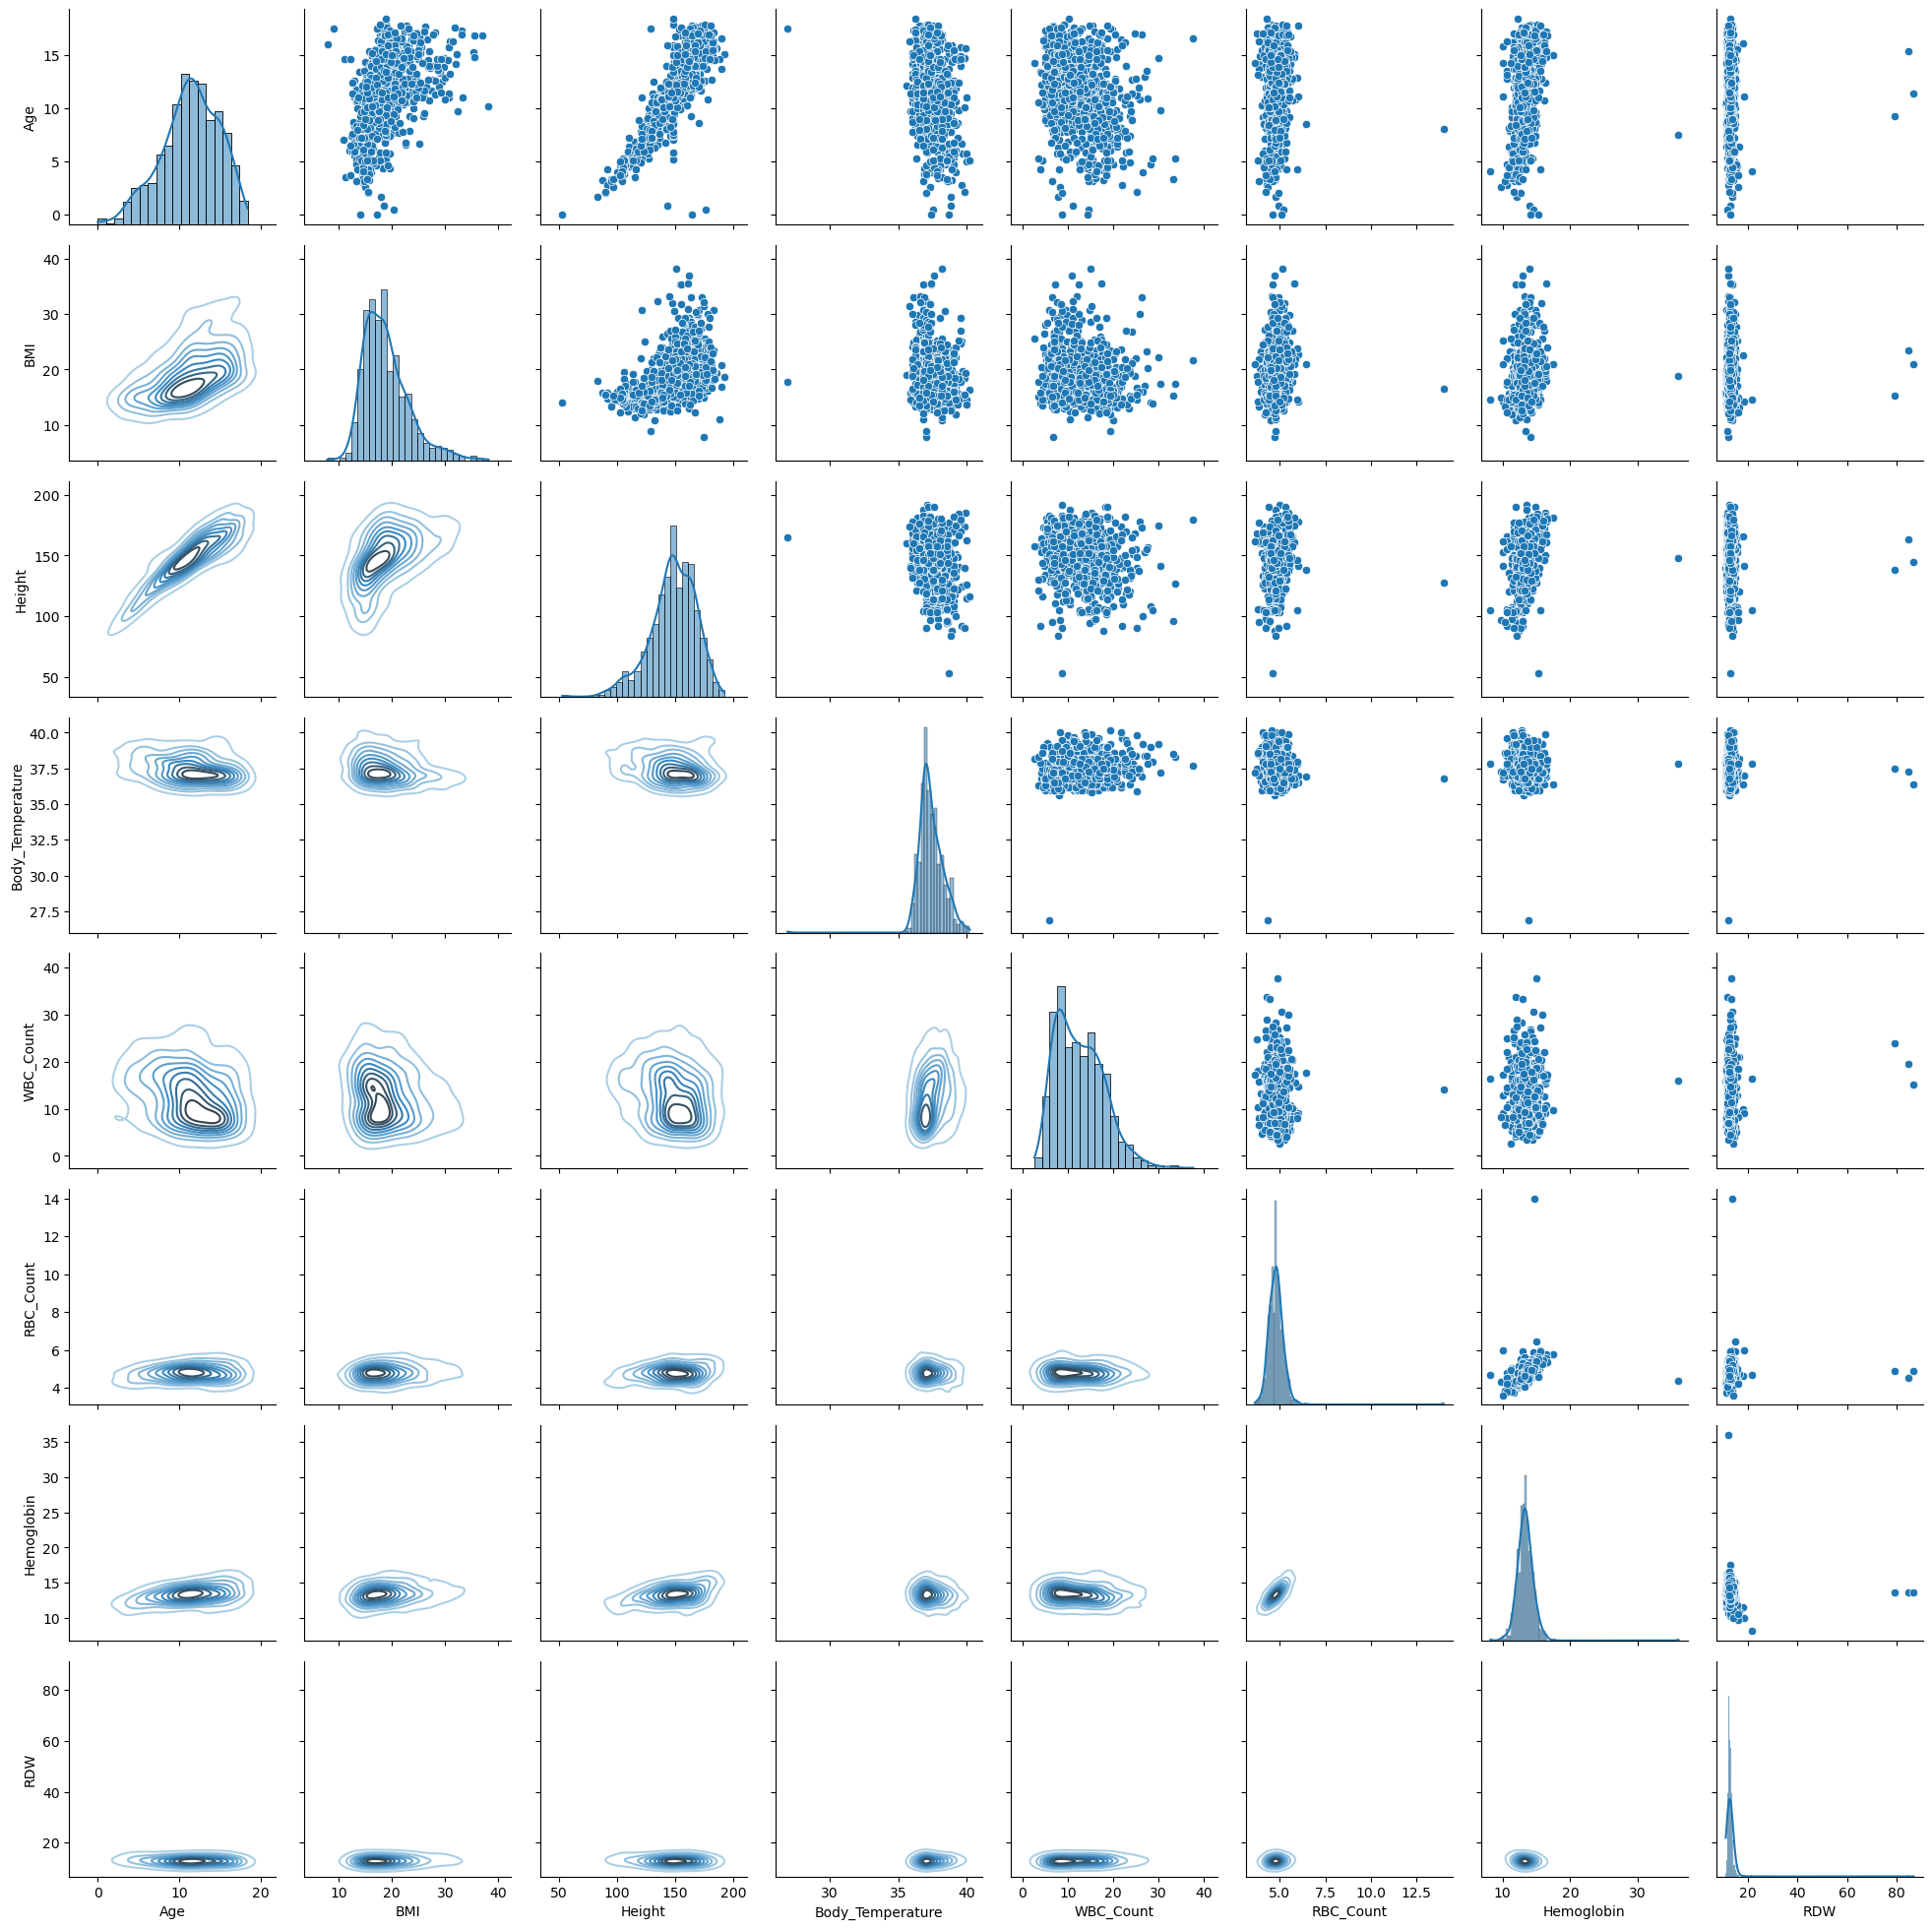

In [33]:
g = sns.PairGrid(X[continuous_features])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.histplot, kde=True)
plt.show()

* Data normalization for continous variables

In [35]:
scaler = MinMaxScaler()
continuous_df_features = pd.DataFrame(scaler.fit_transform(X[continuous_features]), columns=continuous_features)
continuous_df_features.head()

,Age,BMI,Height,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW
0,0.690632,0.299044,0.683453,0.759398,0.145299,0.158960,0.237410,0.013210
1,0.767974,0.793604,0.676259,0.751880,0.156695,0.157996,0.269784,0.019815
2,0.770153,0.510056,0.791367,0.729323,0.301994,0.034682,0.115108,0.013210
3,0.891612,0.421035,0.805755,0.684211,0.250712,0.098266,0.194245,0.026420
4,0.603486,0.299044,0.791367,0.751880,0.156695,0.078998,0.158273,0.031704


* One hot encoding for categorical variables and binary variables

In [39]:
categorical_df_features = pd.concat([X[categorical_features_list],X[binary_features]], axis = 1)
categorical_df_features = pd.get_dummies(categorical_df_features, drop_first = True)
categorical_df_features.head()

,Sex_female,Sex_male,Neutrophilia_no,Neutrophilia_yes,Ketones_in_Urine_++,Ketones_in_Urine_+++,Ketones_in_Urine_Not present,Ketones_in_Urine_no,RBC_in_Urine_++,RBC_in_Urine_+++,...,Loss_of_Appetite_no,Loss_of_Appetite_yes,Dysuria_no,Dysuria_yes,Pathological_Lymph_Nodes_no,Pathological_Lymph_Nodes_yes,Bowel_Wall_Thickening_no,Bowel_Wall_Thickening_yes,Conglomerate_of_Bowel_Loops_no,Conglomerate_of_Bowel_Loops_yes
0,True,False,True,False,True,False,False,False,False,False,...,False,True,True,False,False,True,False,False,False,False
1,False,True,True,False,False,False,False,True,False,False,...,False,True,False,True,False,False,False,False,False,False
2,True,False,True,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,False,False,False
3,True,False,True,False,False,False,False,True,False,False,...,False,True,False,True,False,True,False,False,False,False
4,True,False,True,False,False,False,False,True,False,False,...,False,True,True,False,False,True,False,False,False,False


* PCA analysis for continous variables

Explained variance ratio: [0.54784266 0.1909188  0.12192753]


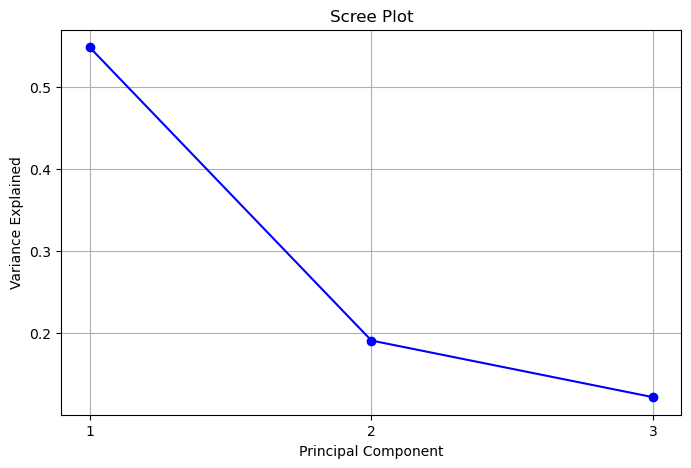

In [41]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(continuous_df_features)

pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

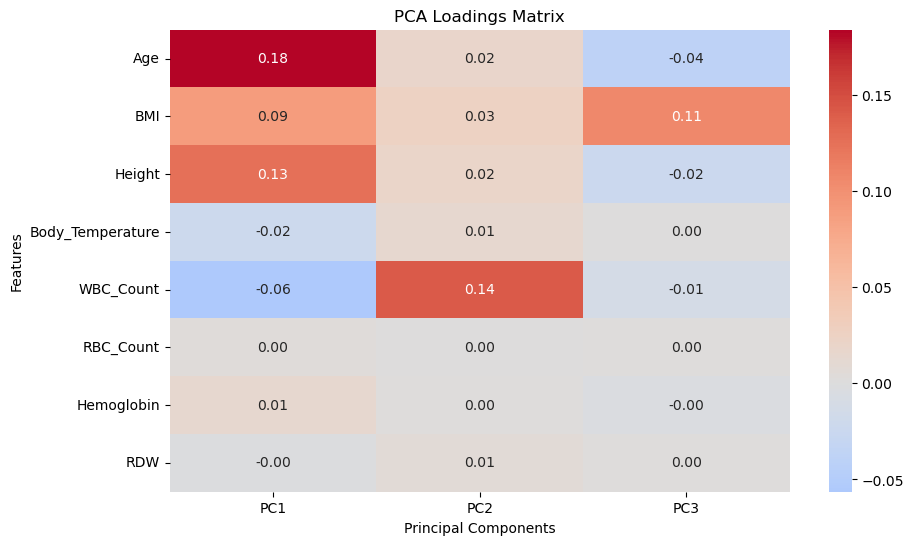

In [44]:

# Create the loadings matrix
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Convert to a DataFrame for better readability
loadings_df = pd.DataFrame(loadings, index=continuous_df_features.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
loadings_df

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, center=0)
plt.title('PCA Loadings Matrix')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()


* To avoid high dimensionality, AGE,BMI,HEIGHT,WBC_COUNT features can be choosen

In [46]:
selected_features = ['Age','BMI','Height','WBC_Count']
continous_df_features = continuous_df_features[selected_features]
continous_df_features.head()

,Age,BMI,Height,WBC_Count
0,0.690632,0.299044,0.683453,0.145299
1,0.767974,0.793604,0.676259,0.156695
2,0.770153,0.510056,0.791367,0.301994
3,0.891612,0.421035,0.805755,0.250712
4,0.603486,0.299044,0.791367,0.156695


* Data integration

In [47]:
# generate x_dataset
X_data = pd.concat([continous_df_features,categorical_df_features], axis = 1)
X_data = pd.concat([X_data,X[integer_features]], axis = 1)
X_data

,Age,BMI,Height,WBC_Count,Sex_female,Sex_male,Neutrophilia_no,Neutrophilia_yes,Ketones_in_Urine_++,Ketones_in_Urine_+++,...,Conglomerate_of_Bowel_Loops_yes,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_Diameter,Neutrophil_Percentage,Segmented_Neutrophils,Thrombocyte_Count,CRP
0,0.690632,0.299044,0.683453,0.145299,True,False,True,False,True,False,...,False,37.0,3.0,4.0,3.0,7.100000,68.2,64.92963,254.0,0.0
1,0.767974,0.793604,0.676259,0.156695,False,True,True,False,False,False,...,False,69.5,2.0,5.0,4.0,7.762651,64.8,64.92963,151.0,3.0
2,0.770153,0.510056,0.791367,0.301994,True,False,True,False,False,False,...,False,62.0,4.0,5.0,3.0,7.762651,74.8,64.92963,300.0,3.0
3,0.891612,0.421035,0.805755,0.250712,True,False,True,False,False,False,...,False,56.0,3.0,7.0,6.0,7.762651,63.0,64.92963,258.0,0.0
4,0.603486,0.299044,0.791367,0.156695,True,False,True,False,False,False,...,False,45.0,3.0,5.0,6.0,7.000000,44.0,64.92963,311.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.675926,0.574349,0.816547,0.250712,True,False,False,True,False,False,...,False,70.0,4.0,8.0,7.0,7.500000,76.6,64.92963,243.0,71.0
778,0.930828,0.415430,0.755396,0.421652,True,False,False,True,False,False,...,True,51.0,6.0,5.0,3.0,7.762651,89.2,64.92963,310.0,245.0
779,0.816449,0.398286,0.712230,0.341880,True,False,True,False,False,False,...,False,46.0,4.0,5.0,3.0,7.762651,68.5,64.92963,328.0,2.0
780,0.392157,0.213320,0.548921,0.433048,False,True,False,True,False,True,...,False,23.9,5.0,9.0,8.0,14.000000,77.0,64.92963,345.0,8.0


In [48]:
y_data = pd.DataFrame(y['Diagnosis'])
y_data['Diagnosis'].unique()

array(['appendicitis', 'no appendicitis', nan], dtype=object)

In [49]:
# validar datos nulos en variable dependiente y presentar información como binaria para clasificador

data_nulls = y_data.isnull().sum()
df_nulls = pd.DataFrame(data_nulls, columns = ['Nulls'])
df_nulls.reset_index(inplace = True)
df_nulls.rename(columns = {'index':'Feature'}, inplace = True)
df_nulls.sort_values(by = 'Nulls', ascending= False)

,Feature,Nulls
0,Diagnosis,2


In [50]:
y_data.loc[y_data['Diagnosis']=='appendicitis'] = 1
y_data.loc[y_data['Diagnosis']=='no appendicitis'] = 0
y_data['Diagnosis'].unique()



array([1, 0, nan], dtype=object)

In [51]:
# Resulting dataframe
uci_df = pd.concat([X_data,y_data], axis = 1)

# exlucde null records from uci_df
uci_df = uci_df.loc[uci_df['Diagnosis'].notnull()]
uci_df.head()

,Age,BMI,Height,WBC_Count,Sex_female,Sex_male,Neutrophilia_no,Neutrophilia_yes,Ketones_in_Urine_++,Ketones_in_Urine_+++,...,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_Diameter,Neutrophil_Percentage,Segmented_Neutrophils,Thrombocyte_Count,CRP,Diagnosis
0,0.690632,0.299044,0.683453,0.145299,True,False,True,False,True,False,...,37.0,3.0,4.0,3.0,7.100000,68.2,64.92963,254.0,0.0,1
1,0.767974,0.793604,0.676259,0.156695,False,True,True,False,False,False,...,69.5,2.0,5.0,4.0,7.762651,64.8,64.92963,151.0,3.0,0
2,0.770153,0.510056,0.791367,0.301994,True,False,True,False,False,False,...,62.0,4.0,5.0,3.0,7.762651,74.8,64.92963,300.0,3.0,0
3,0.891612,0.421035,0.805755,0.250712,True,False,True,False,False,False,...,56.0,3.0,7.0,6.0,7.762651,63.0,64.92963,258.0,0.0,0
4,0.603486,0.299044,0.791367,0.156695,True,False,True,False,False,False,...,45.0,3.0,5.0,6.0,7.000000,44.0,64.92963,311.0,0.0,1


In [52]:

#Resulting dataframe
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
path = os.path.join(parent_directory,'data/processed/uci_df.csv')
print(path)
uci_df.to_csv(path)

/Users/kevin/Desktop/MLOps/mlops_tec/mlops_tarea1/data/processed/uci_df.csv


# Versionado de datos

* Utilizar herramientas de versionado de datos para mantener un registro de cambios y versiones de los conjuntos de datos utilizados.
* Documentar todas las modificaciones realizadas en los datos.

**Files were added for dvc control and tracking is avialable under folders processed and raw with .csv.dvc extensions**

**DVC remote local storage was configured within /data/dvc_storage/**

# Construcción, ajuste y evaluación de modelos de machine learning



* Split entrenamiento y prueba

In [53]:
y_df = uci_df[y_data.columns].astype(int)
X_df = uci_df[X_data.columns]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, train_size = .8, test_size=0.2, random_state=42, stratify=y_df)

* Seleccionar algoritmos de Machine Learning adecuados para resolver el problema planteado.


In [54]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

* Entrenar los modelos utilizando los datos preprocesados.

In [55]:
rf_classifier.fit(X_train, np.array(y_train).flatten())
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy of the model:", round(accuracy,4))


Accuracy of the model: 0.9231


* Evaluar los modelos utilizando métricas de rendimiento específicas.

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        63
           1       0.92      0.96      0.94        93

    accuracy                           0.92       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.92      0.92      0.92       156



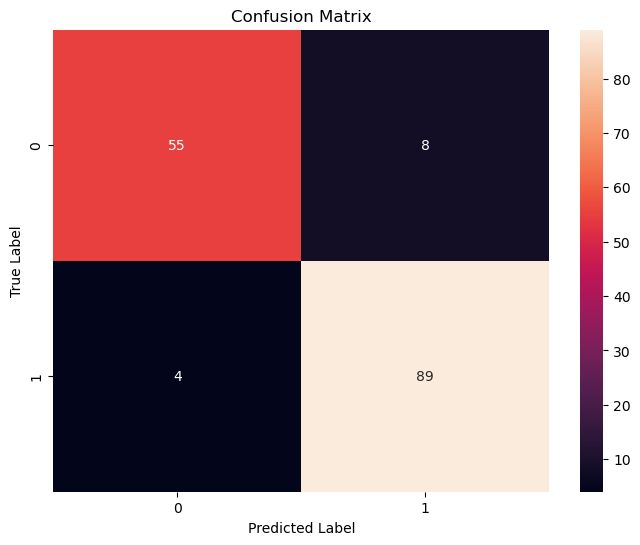

In [56]:

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot = True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

* Realizar ajustes de hiperparámetros para optimizar el rendimiento del modelo.

In [57]:

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5,8],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, np.array(y_train).flatten())

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


* Entrenamiento con mejora de hiper parámetros

Accuracy of the model: 0.9231

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        63
           1       0.93      0.95      0.94        93

    accuracy                           0.92       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.92      0.92      0.92       156



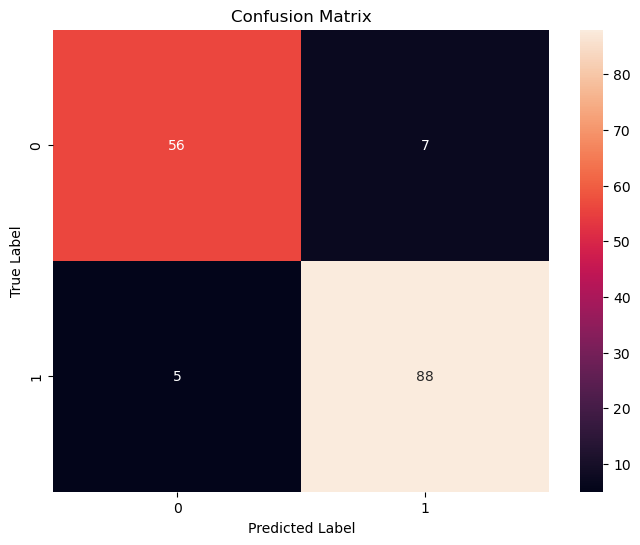

In [58]:
rf_classifier_hp = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators']
                                          ,random_state=42
                                          ,max_depth = grid_search.best_params_['max_depth'] 
                                          ,min_samples_split = grid_search.best_params_['min_samples_split']                                           
                                          )
rf_classifier_hp.fit(X_train, np.array(y_train).flatten())
y_pred_hp = rf_classifier_hp.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_hp)
confusion = confusion_matrix(y_test, y_pred_hp)

# Print accuracy and confusion matrix
print("Accuracy of the model:", round(accuracy,4))
print("")

print("Classification Report:")
print(classification_report(y_test, y_pred_hp))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot = True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
